In [1]:
import numpy as np
import math
import time
import xlrd
import matplotlib.pyplot as plt
from data_extract import *
from data_preprocess import *
from signal_process import *
import copy


# Data Extraction

In [2]:
gdf_fname = "C:/Users/Liangyu/Desktop/BME725/Final Project/Data/S01_ME/motorexecution_subject1_run1.gdf"
compressed_fname = "S1R1ME.bz2"

t1 = time.time()
HDR, data = read_data(gdf_fname)

# filter data with bandpass filter
for i in range(0,np.shape(data)[1]):
    data[:,i] = butter_bandpass_filter(data[:,i], 0.3, 120, HDR.SampleRate, order=4)

seqs_v_class_map = segregate_data_into_classes(HDR, data)
#compress_segregated_data(seqs_v_class_map, compressed_fname)
print("Done processing file in %f s\n" % (time.time() - t1))

# define sampling rate
fs = int(HDR.SampleRate/2)

Finished reading header
Read header of C:/Users/Liangyu/Desktop/BME725/Final Project/Data/S01_ME/motorexecution_subject1_run1.gdf in 0.004995 s

Finished reading data
Read data of C:/Users/Liangyu/Desktop/BME725/Final Project/Data/S01_ME/motorexecution_subject1_run1.gdf in 47.385420 s

Finished segregating data into classes in 0.475727 s

Done processing file in 49.005044 s



# load the channel labels

In [3]:
# Give the location of the file that maps eeg index to channel name 
loc = ("C:/Users/Liangyu/Desktop/BME725/Final Project/ChannelLabel.xlsx") 

# Open the xls file
wb = xlrd.open_workbook(loc) 
sheet = wb.sheet_by_index(0) 

# Remove artifacts

In [4]:
t1 = time.time()

# set parameters
nBins = 20
threshold = 5        # in standard deviation
thresholdSig = 200   # in uV
copyLib = True
disp = False         # True to display the rejected channels
EOG_Chann = [61,62,63]

# rejects based on joint probability
rejChanProb = markArtifactJointProb(seqs_v_class_map, nBins, threshold)

# reject based on kurtosis
rejChanKurt = markArtifactKurtosis(seqs_v_class_map, threshold)

# reject based on eeg signal value
rejChanThresh = markArtifactSigVal(seqs_v_class_map, thresholdSig)

# concatenate the index of the rejected channels
rejChan = np.zeros((1,3),dtype=int)
rejChan = np.concatenate((rejChan, rejChanProb), axis=0) if np.size(rejChanProb)>1 else rejChan
rejChan = np.concatenate((rejChan, rejChanKurt), axis=0) if np.size(rejChanKurt)>1 else rejChan
rejChan = np.concatenate((rejChan, rejChanThresh), axis=0) if np.size(rejChanThresh)>1 else rejChan
rejChan = np.delete(rejChan, (0), axis=0)

# get the trials that should be rejected because the EOG detected eye movement
rejTrial = np.zeros((1,3),dtype=int)
c = []
for i in range(0, np.shape(rejChan)[0]):
    if rejChan[i,2] in EOG_Chann:
        rejTrial = np.append(rejTrial, [rejChan[i,:]], axis=0)

rejTrial = np.delete(rejTrial, (0), axis=0)

# set the rejected channels to 0
seqs_v_class_map_noArtifact = rejectChannels(seqs_v_class_map, rejChan, copyLib, disp)

# reject entire trials by setting all values to 0 when the EOG of that trial is rejected as an artifact
seqs_v_class_map_noArtifact = rejectTrials(seqs_v_class_map_noArtifact, rejChan, copyLib, disp)



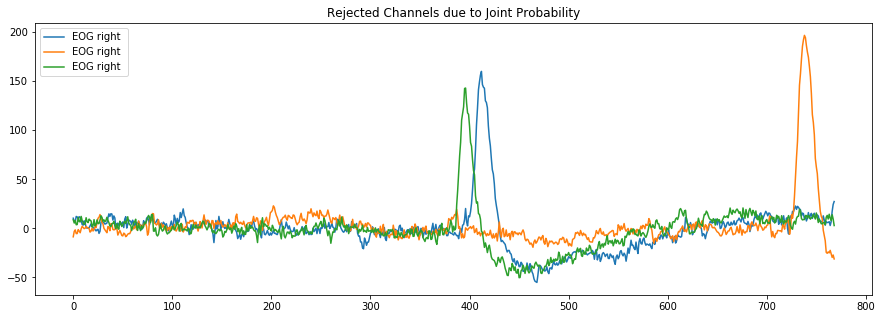

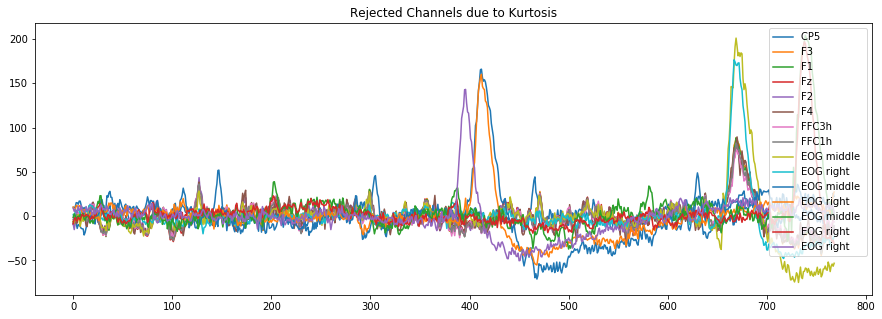

In [5]:
# plot the channels that were rejected due to joint probability
if np.size(rejChanProb)>1:
    plt.figure(figsize = (15,5))
    plt.title('Rejected Channels due to Joint Probability')
    for i in range(np.shape(rejChanProb)[0]):
        plt.plot(seqs_v_class_map[rejChanProb[i,0]][rejChanProb[i,1]][:,rejChanProb[i,2]], \
                 label=sheet.cell_value(rejChanProb[i,2]+1, 1))
    plt.legend()

# plot the channels that were rejected due to kurtosis
if np.size(rejChanKurt)>1:
    plt.figure(figsize = (15,5))
    plt.title('Rejected Channels due to Kurtosis')
    for i in range(np.shape(rejChanKurt)[0]):
        plt.plot(seqs_v_class_map[rejChanKurt[i,0]][rejChanKurt[i,1]][:,rejChanKurt[i,2]], \
                 label=sheet.cell_value(rejChanKurt[i,2]+1, 1))
    plt.legend()

# plot the channels that were rejected due to eeg signal value
if np.size(rejChanThresh)>1:
    plt.figure(figsize = (15,5))
    plt.title('Rejected Channels due to Absolute Deviation from Mean')
    for i in range(np.shape(rejChanThresh)[0]):
        plt.plot(seqs_v_class_map[rejChanThresh[i,0]][rejChanThresh[i,1]][:,rejChanThresh[i,2]])
        plt.legend()

# Window the 1D eeg vector data into time bins

In [6]:
# window size parameters
width = int(fs/4)
nOverlap = int(fs/8)
initTime = 0
finTime = int(fs*3)-nOverlap

# segment the data based into windows
seqs_v_class_map_binned = data_segmentation(seqs_v_class_map_noArtifact, initTime, finTime, width, nOverlap)

# show the old and new array dimensions for class 1
print(np.shape(seqs_v_class_map[1]))
print(np.shape(seqs_v_class_map_binned[1]))

(6, 769, 64)
(6, 23, 64, 64)


# Convert 1D eeg vector to 2D spatial array

In [7]:
# empirically determined pattern
startNdx = [0,0,0,0,1,1,2,3,4,6];
endNdx   = [4,5,6,7,7,8,8,8,8,7];

# initialize an empty map
maps = numpy.zeros((61,2),dtype=int)
k = 0
# fill that map with the row and column positions of each electrode
for i in range(0, np.size(startNdx)):
    tmpCol = np.arange(startNdx[i], endNdx[i]+1, 1).tolist()
    tmpRow = np.arange(endNdx[i], startNdx[i]-1, -1).tolist()
    
    for j in range(0,np.size(tmpRow)):
        maps[k][:] = [tmpRow[j], tmpCol[j]]
        k = k + 1

# populate the mesh with the electrodes
mesh = [ [ "" for y in range(0,9) ] for x in range(0,9) ] 
for chan in range(0,np.shape(maps)[0]):
    mesh[maps[chan][0]][maps[chan][1]] = sheet.cell_value(chan+1, 1)

# print the 2D mesh of channels
for x in range(0,9): 
    print(mesh[x])
    
# change the 1D eeg signal to 2D eeg signal based on the defined map
seqs_v_class_map_noArtifact_mesh = data_1D_to_2D(seqs_v_class_map_noArtifact, 9, 9, maps)

# print the size of the new array for the first class
print(np.shape(seqs_v_class_map_noArtifact_mesh[1]))

['', '', '', '', 'F4 ', 'FFC6h ', 'FC6 ', 'FTT8h ', '']
['', '', '', 'F2 ', 'FFC4h ', 'FC4 ', 'FCC6h ', 'C6 ', 'TTP8h ']
['', '', 'Fz ', 'FFC2h ', 'FC2 ', 'FCC4h ', 'C4 ', 'CCP6h ', 'CP6 ']
['', 'F1 ', 'FFC1h ', 'FCz ', 'FCC2h ', 'C2 ', 'CCP4h ', 'CP4 ', 'CPP6h ']
['F3 ', 'FFC3h ', 'FC1 ', 'FCC1h ', 'Cz ', 'CCP2h ', 'CP2 ', 'CPP4h ', 'P4 ']
['FFC5h ', 'FC3 ', 'FCC3h ', 'C1 ', 'CCP1h ', 'CPz ', 'CPP2h ', 'P2 ', '']
['FC5 ', 'FCC5h ', 'C3 ', 'CCP3h ', 'CP1 ', 'CPP1h ', 'Pz ', 'PPO2h ', '']
['FTT7h ', 'C5 ', 'CCP5h ', 'CP3 ', 'CPP3h ', 'P1 ', 'PPO1h ', '', '']
['', 'TTP7h ', 'CP5 ', 'CPP5h ', 'P3 ', '', '', '', '']
(6, 769, 9, 9)


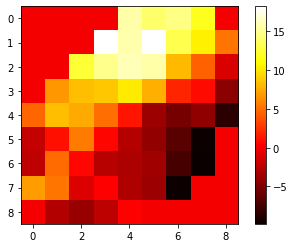

In [8]:
#plot a sample 2D image of the 61 channel electrode
sampleMesh = seqs_v_class_map_noArtifact_mesh[1][0][0]
plt.imshow(sampleMesh, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# Window the 2D eeg array data into time bins

In [9]:
# window size parameters
width = int(fs/4)
nOverlap = int(fs/8)
initTime = 0
finTime = int(fs*3)-nOverlap

# segment the data based into windows
seqs_v_class_map_binned2 = data_segmentation(seqs_v_class_map_noArtifact_mesh, initTime, finTime, width, nOverlap)

# show the old and new array dimensions for class 1
print(np.shape(seqs_v_class_map[1]))
print(np.shape(seqs_v_class_map_binned2[1]))

(6, 769, 64)
(6, 23, 64, 9, 9)


In [10]:
print("Done pre-processing files file in %f s\n" % (time.time() - t1))

Done pre-processing files file in 6.862908 s

